## Deep Learning
### Examen Agosto 2022

#### Alumna: Ariadna Garmendia

#### 2) Utilizando el mismo dataset que en el link anterior, diseñar una red neuronal que haga un overfitting sobre el dataset. ¿Cómo saben que la red neuronal está haciendo overfitting? Agregar regularización y encontrar los parámetros correctos para lograr un buen fit. Explicar el procedimiento realizado.


In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy import stats
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics

In [67]:
dataset = pd.read_csv('dataset_1.csv')
dataset = pd.DataFrame(dataset)
dataset.head()

,# X,Y
0,1.791979,4.952906
1,0.846885,1.424248
2,1.000300,0.454364
3,1.884188,6.681510
4,0.889089,1.211691


In [68]:
dataset.rename(columns = {'# X':'X'}, inplace = True)
dataset.head()

,X,Y
0,1.791979,4.952906
1,0.846885,1.424248
2,1.000300,0.454364
3,1.884188,6.681510
4,0.889089,1.211691


In [69]:
X = dataset.X.to_numpy()
y = dataset.Y.to_numpy()

X.shape, y.shape

((10000,), (10000,))

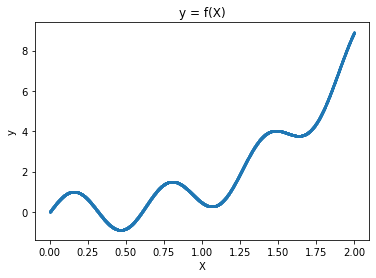

In [70]:
# Grafico función de entrada
plt.figure()
plt.scatter(X, y,1)
plt.title('y = f(X)')
plt.ylabel('y')
plt.xlabel('X')
plt.show()

Normalizo los datos

In [71]:
X.shape, y.shape

((10000,), (10000,))

In [72]:
X_train = X.reshape(-1,1)
y_train = y.reshape(-1,1)


Verifico que las dimensiones quedaron bien

In [73]:
X_train.shape, y_train.shape 


((10000, 1), (10000, 1))

In [74]:
X_train[0:5, 0]

array([1.7919792 , 0.84688469, 1.00030003, 1.88418842, 0.88908891])

Código para la NNet (uso el código visto en clase)

In [75]:
class MyDataset(Dataset):

    def __init__(self, X, y): # Recibe todo el dataset
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):  # Devuelve cantidad de filas que tiene el DS
        return self.X.shape[0]

    def __getitem__(self, idx): # Esto es para poder devolver un item, muestras para iterar. Devolver una tupla con estos dos elementos
        return self.X[idx], self.y[idx]

In [76]:
train = MyDataset(X_train, y_train)


Voy a utilizar batch_size = 64

In [77]:
# El Dataloader (Clase de Pytorch) sirve para generar el batch
train_dataloader = DataLoader(train, batch_size=64, shuffle=True) # Shuffle cambia los datos del batch por cada epoch


In [78]:
class NNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=1, out_features=100, bias=True)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=100, out_features=50, bias=True)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=50, out_features=20, bias=True)
        self.relu_3 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=20, out_features=1, bias=True)

    def forward(self, x): # x.shape -> 64 x 13
        x = self.linear_1(x) # x.shape -> 64 x 100 
        x = self.relu_1(x) # x.shape -> 64 x 100
        x = self.linear_2(x) # x.shape -> 64 x 50
        x = self.relu_2(x) # x.shape -> 64 x 50
        x = self.linear_3(x) # x.shape -> 64 x 50
        x = self.relu_3(x) # x.shape -> 64 x 50
        x = self.output(x) # x.shape -> 64 x 1
        return x

In [79]:
nnet = NNet()

Imprimo los detalles de la red:

In [80]:
nnet

NNet(
  (linear_1): Linear(in_features=1, out_features=100, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=100, out_features=50, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=50, out_features=20, bias=True)
  (relu_3): ReLU()
  (output): Linear(in_features=20, out_features=1, bias=True)
)

Utilizo optimizador Adam y MSE para la Loss function:

In [81]:
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss(reduction="sum")

In [82]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)

cpu


Entrenamiento (Nro epochs: epochs_nbr)

In [83]:
epochs_nbr = 1000

In [84]:
nnet.to(device)

loss_list = []
y_hat_list = []
#loss_valid_list = []

for epoch in range(epochs_nbr):

    running_loss = 0
    running_y_score = []
    running_y_true = []
    running_X_batch = []
   
    
    for i, data in enumerate(train_dataloader):

        # datos del batch
        X_batch, y_batch = data 
        X_batch = X_batch.to(device).float()
        Y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        y_batch_score = (nnet(X_batch))
        

        # backpropagation
        loss = loss_function(y_batch_score, Y_batch) # calcula el loss
        loss.backward() # hacer los gradientes del loss

        # actualización de parametros
        optimizer.step() 

        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy()) # Acumula predicción (para graficar lo traemos de GPU a CPU con detach)
        running_y_true += list(Y_batch.detach().cpu().numpy()) # Acumula y_true
        running_X_batch += list(X_batch.detach().cpu().numpy()) #Guardo los X para graficar(por el reshuffle no quedan en orden)
    
    # metrics
    loss_list.append(running_loss)
    print(f"Epoch {epoch} | Training loss: {running_loss} ")
    

    

Epoch 0 | Training loss: 26388.115997314453 
Epoch 1 | Training loss: 5022.942889690399 
Epoch 2 | Training loss: 3896.867395401001 
Epoch 3 | Training loss: 3509.984739303589 
Epoch 4 | Training loss: 3093.444085597992 
Epoch 5 | Training loss: 2698.627546310425 
Epoch 6 | Training loss: 2385.0160191059113 
Epoch 7 | Training loss: 2181.3693627119064 
Epoch 8 | Training loss: 1956.0179653167725 
Epoch 9 | Training loss: 1739.1268379688263 
Epoch 10 | Training loss: 1513.6937084197998 
Epoch 11 | Training loss: 1312.4784398078918 
Epoch 12 | Training loss: 1074.4267982244492 
Epoch 13 | Training loss: 839.0097593069077 
Epoch 14 | Training loss: 637.4420027732849 
Epoch 15 | Training loss: 442.2571994662285 
Epoch 16 | Training loss: 319.2421937584877 
Epoch 17 | Training loss: 232.47764718532562 
Epoch 18 | Training loss: 149.79294802248478 
Epoch 19 | Training loss: 102.93623919039965 
Epoch 20 | Training loss: 75.15173856168985 
Epoch 21 | Training loss: 62.16167476773262 
Epoch 22 

Preparo datos para graficar y verifico dimensiones

In [85]:
y_predicted =np.array(running_y_score).reshape(-1)
y_true =np.array(running_y_true).reshape(-1)
X_nn = np.array(running_X_batch).reshape(-1)
y_predicted.shape, y_true.shape, X_nn.shape

((10000,), (10000,), (10000,))

Plot

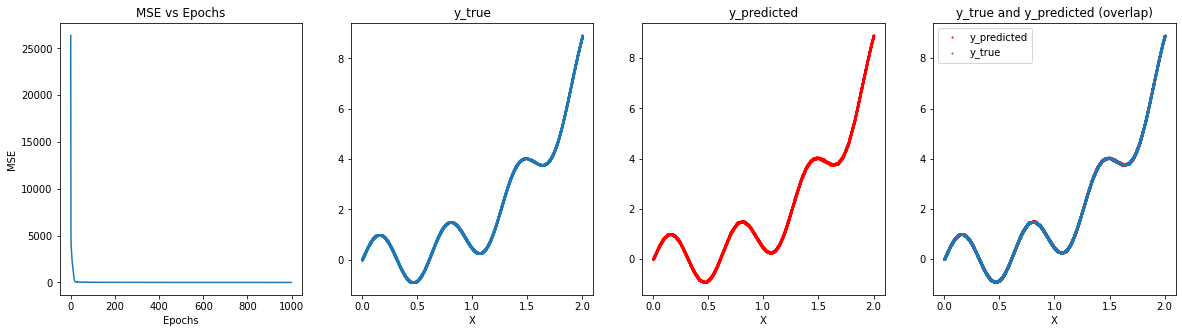

In [87]:
plt.figure(figsize=[20,5])

plt.subplot(141)
plt.plot(range(0, len(loss_list)), loss_list)
plt.title('MSE vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(142)
plt.scatter(X_nn,y_true,1)
plt.title('y_true')
plt.xlabel('X')

plt.subplot(143)
plt.scatter(X_nn,y_predicted,1,'r')
plt.title('y_predicted')
plt.xlabel('X')

plt.subplot(144)
plt.scatter(X_nn,y_predicted,1, 'r')
plt.scatter(X_nn,y_true,1)
plt.title('y_true and y_predicted (overlap)')
plt.xlabel('X')
plt.legend(['y_predicted', 'y_true'])

Conclusión: se observa en los graficos como ahora el modelo hace overfitting - todos los puntos que la red neuronal predice, coinciden exactamente con los valores del "y" verdadero.

#### Implemento Regularización para prevenir el overfitting

1) Implemento regularización con el método Dropout (p=0.2) en las 3 capas intermedias

In [88]:
X_train.shape, y_train.shape

((10000, 1), (10000, 1))

In [89]:
X_train[0:5, 0]

array([1.7919792 , 0.84688469, 1.00030003, 1.88418842, 0.88908891])

In [90]:
train_do = MyDataset(X_train, y_train)

In [91]:
# El Dataloader (Clase de Pytorch) sirve para generar el batch
train_dataloader_do = DataLoader(train_do, batch_size=64, shuffle=True) # Shuffle cambia los datos del batch por cada epoch

In [92]:
class NNet_do(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=1, out_features=100, bias=True)
        self.dropout_1 = torch.nn.Dropout(p =0.2)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=100, out_features=50, bias=True)
        self.dropout_2 = torch.nn.Dropout(p =0.2)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=50, out_features=20, bias=True)
        self.dropout_3 = torch.nn.Dropout(p =0.2)
        self.relu_3 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=20, out_features=1, bias=True)

    def forward(self, x): # x.shape -> 64 x 1
        x = self.linear_1(x) # x.shape -> 64 x 100 
        x = self.dropout_1(x)
        x = self.relu_1(x) # x.shape -> 64 x 100
        x = self.linear_2(x) # x.shape -> 64 x 50
        x = self.dropout_2(x)
        x = self.relu_2(x) # x.shape -> 64 x 50
        x = self.linear_3(x) # x.shape -> 64 x 50
        x = self.dropout_3(x)
        x = self.relu_3(x) # x.shape -> 64 x 20
        x = self.output(x) # x.shape -> 64 x 1
        return x

Utilizo optimizador de Adam y MSE como loss function por ser un problema de Regresión

In [93]:
nnet_do = NNet_do()
optimizer = torch.optim.Adam(nnet_do.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss(reduction="sum")

In [94]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)

cpu


In [95]:
epochs_nbr = 3000

In [96]:
  
nnet_do.to(device)

loss_list = []


for epoch in range(epochs_nbr):

    running_loss = 0
    running_y_score = []
    running_y_true = []
    running_X_batch = []


    for i, data in enumerate(train_dataloader_do):

        # datos del batch
        X_batch, y_batch = data 
        X_batch = X_batch.to(device).float()
        Y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        y_batch_score = (nnet_do(X_batch))
        

        # backpropagation
        loss = loss_function(y_batch_score, Y_batch) # calcula el loss
        loss.backward() # hacer los gradientes del loss

        # actualización de parametros
        optimizer.step() 

        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy()) # Acumula predicción (para graficar lo traemos de GPU a CPU con detach)
        running_y_true += list(Y_batch.detach().cpu().numpy()) # Acumula y_true
        running_X_batch += list(X_batch.detach().cpu().numpy()) #Guardo los X para graficar(por el reshuffle no quedan en orden)

    # metrics
    loss_list.append(running_loss)
    print(f"Epoch {epoch} | Training loss: {running_loss} ")
    y_predicted =np.array(running_y_score).reshape(-1)
    y_true =np.array(running_y_true).reshape(-1)
    X_nn = np.array(running_X_batch).reshape(-1)




    

Epoch 0 | Training loss: 24860.074016571045 
Epoch 1 | Training loss: 8849.918315887451 
Epoch 2 | Training loss: 8246.535875320435 
Epoch 3 | Training loss: 7605.748750209808 
Epoch 4 | Training loss: 7335.544551849365 
Epoch 5 | Training loss: 6662.423166275024 
Epoch 6 | Training loss: 6629.14796257019 
Epoch 7 | Training loss: 6329.0881996154785 
Epoch 8 | Training loss: 6140.3489818573 
Epoch 9 | Training loss: 6278.682428359985 
Epoch 10 | Training loss: 5820.761699676514 
Epoch 11 | Training loss: 5666.862797260284 
Epoch 12 | Training loss: 5207.353302955627 
Epoch 13 | Training loss: 4867.162895202637 
Epoch 14 | Training loss: 4538.916679859161 
Epoch 15 | Training loss: 4271.235792636871 
Epoch 16 | Training loss: 4003.6731543540955 
Epoch 17 | Training loss: 3701.224847793579 
Epoch 18 | Training loss: 3628.573302268982 
Epoch 19 | Training loss: 3695.0709381103516 
Epoch 20 | Training loss: 3628.243869781494 
Epoch 21 | Training loss: 3599.4113268852234 
Epoch 22 | Trainin

In [97]:
y_predicted =np.array(running_y_score).reshape(-1)
y_true =np.array(running_y_true).reshape(-1)
X_nn = np.array(running_X_batch).reshape(-1)
y_predicted.shape, y_true.shape, X_nn.shape

((10000,), (10000,), (10000,))

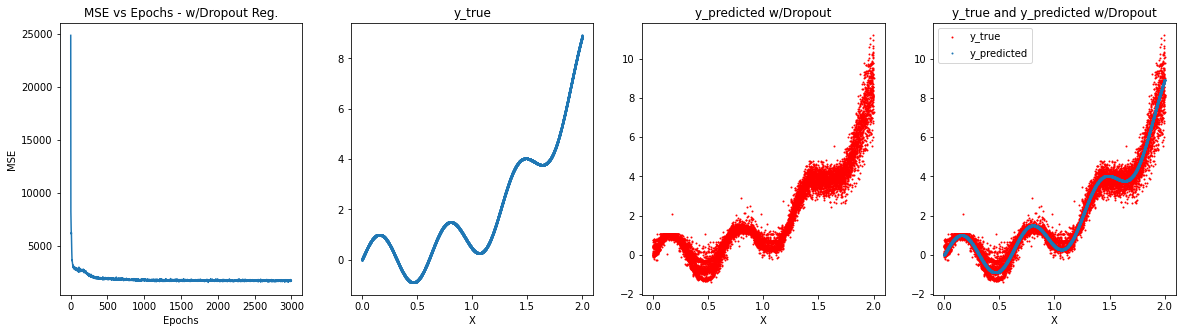

In [98]:
plt.figure(figsize=[20,5])

plt.subplot(141)
plt.plot(range(0, len(loss_list)), loss_list)
plt.title('MSE vs Epochs - w/Dropout Reg.')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(142)
plt.scatter(X_nn,y_true,1)
plt.title('y_true')
plt.xlabel('X')

plt.subplot(143)
plt.scatter(X_nn,y_predicted,1,'r')
plt.title('y_predicted w/Dropout')
plt.xlabel('X')

plt.subplot(144)
plt.scatter(X_nn,y_predicted,1, 'r')
plt.scatter(X_nn,y_true,1)
plt.title('y_true and y_predicted w/Dropout')
plt.xlabel('X')
plt.legend(['y_true', 'y_predicted'])

Se observa el efecto de la regulación.